In [1]:
from google.colab import drive
drive.mount('/content/drive/')

root_dir = "/content/drive/MyDrive/"
#import os
#os.chdir(root_dir + 'nuswide/nuswide/')

Mounted at /content/drive/


In [17]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

df = pd.read_csv('/content/drive/MyDrive/Project/Final_Dataset/notebooks/proposed model/nuswide/nuswide2.csv')


def preprocess_text(text):
    if pd.isna(text):
        return ''

    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    text = re.sub('\s+', ' ', text).strip()
    return text


df['Text'] = df['Text'].apply(preprocess_text)

df.to_csv('/content/drive/MyDrive/Project/Final_Dataset/notebooks/proposed model/nuswide/preprocessed_file_first.csv', index=False)

####################################################
####################################################

import pandas as pd

file_path = '/content/drive/MyDrive/Project/Final_Dataset/notebooks/proposed model/nuswide/preprocessed_file_first.csv'

df = pd.read_csv(file_path)

df = df.dropna(subset=['Text'], how='any')
df = df.drop_duplicates(subset=['Text'])


df.to_csv('/content/drive/MyDrive/Project/Final_Dataset/notebooks/proposed model/nuswide/cleaned_file_first.csv', index=False)


In [18]:
import pandas as pd

# Load the CSV file into a DataFrame
df = pd.read_csv('/content/drive/MyDrive/Project/Final_Dataset/notebooks/proposed model/nuswide/cleaned_file_first.csv')

# Remove the "#" symbol and join the hashtags into a single string
df['Pre_hashtag'] = df['Hashtag'].apply(lambda x: ' '.join(x.split('#')[1:]))

# Print the DataFrame to verify the changes
print(df.head())

# Save the modified DataFrame back to a CSV file
df.to_csv('/content/drive/MyDrive/Project/Final_Dataset/notebooks/proposed model/nuswide/modified_file_first.csv', index=False)


         File Name   domain                  Text  \
0  0426_2285945634  airport      ready for takeof   
1   0671_483048408  airport   busy airport hustle   
2   0465_247609520  airport  waiting for boarding   
3  0540_2218117161  airport    airport adventures   
4  0334_2114912741  airport           flying high   

                                             Hashtag  Pre_hashtags  \
0                 #avgeek #pilot #travel #plane #fly           NaN   
1  #aviation #aviationlovers #boeing #aircraft #a...           NaN   
2  #flying #airplane #instagramaviation #planespo...           NaN   
3  #instaplane #flight #aviationdaily #cabincrew ...           NaN   
4  #airline #aviationgeek #planespotter #pilotlif...           NaN   

                                         Pre_hashtag  
0                  avgeek  pilot  travel  plane  fly  
1  aviation  aviationlovers  boeing  aircraft  av...  
2  flying  airplane  instagramaviation  planespot...  
3  instaplane  flight  aviationdaily  ca

In [19]:
import os
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Concatenate


# Load CSV file with image names and text
csv_file = '/content/drive/MyDrive/Project/Final_Dataset/notebooks/proposed model/nuswide/modified_file_first.csv'
df = pd.read_csv(csv_file)

# Initialize InceptionV3 model
image_model = InceptionV3(weights='imagenet')
image_model = Model(inputs=image_model.input, outputs=image_model.layers[-2].output)

# Initialize Universal Sentence Encoder (USE) for text embedding
text_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

# Directory containing images
image_directory = '/content/drive/MyDrive/Project/Final_Dataset/notebooks/proposed model/nuswide/images'

image_features = {}
text_features = {}
i=1
# Process image features
for img_name in df['File Name']:
    print(i)
    i=i+1
    img_path = os.path.join(image_directory, img_name)
    image = load_img(img_path+'.jpg', target_size=(299, 299))  # InceptionV3 input size
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)

    feature = image_model.predict(image, verbose=0)

    # Extract image ID (assuming image names have an extension, e.g., '.jpg')
    image_id = os.path.splitext(img_name)[0]

    image_features[image_id] = feature
with open('/content/drive/MyDrive/Project/Final_Dataset/notebooks/proposed model/nuswide/imfeatures_first.pkl', 'wb') as f:
    pickle.dump(image_features, f)

# Process text features
for idx, text in enumerate(df['Text']):
    image_id = os.path.splitext(df.loc[idx, 'File Name'])[0]
    text_feature = text_model([text])[0].numpy()
    text_features[image_id] = text_feature

# Merge image and text features
all_features = {}
for image_id, image_feature in image_features.items():
    if image_id in text_features:
        text_feature = text_features[image_id]
        text_feature = np.expand_dims(text_feature, axis=0)  # Add a new dimension
        merged_feature = np.concatenate([image_feature, text_feature], axis=1)
        all_features[image_id] = merged_feature


# Save merged features dictionary using pickle
with open('/content/drive/MyDrive/Project/Final_Dataset/notebooks/proposed model/nuswide/2dmerged_features_first.pkl', 'wb') as f:
    pickle.dump(all_features, f)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153


In [20]:
import os
import pickle
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

csv_file = '/content/drive/MyDrive/Project/Final_Dataset/notebooks/proposed model/nuswide/modified_file_first.csv'
df = pd.read_csv(csv_file)

# load features from pickle
with open('/content/drive/MyDrive/Project/Final_Dataset/notebooks/proposed model/nuswide/2dmerged_features_first.pkl', 'rb') as f:
    features = pickle.load(f)

In [21]:
# create mapping of image to captions
mapping = {}
# process lines
for pre_hashtags,file_name in zip(df['Pre_hashtag'], df['File Name']):
    image_id = file_name.split('.')[0]
    caption = pre_hashtags
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

#print("mapping:",mapping)

def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # del spaceslete digits, special chars, etc.,
            caption = caption.replace('[^A-Za-z]', '')
            # delete additiona
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

clean(mapping)

all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)


# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)


image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.80)
train = image_ids[:split]
test = image_ids[split:]



# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0




512


In [22]:
test

['0098_2192794779',
 '0080_76684763',
 '0440_2479584233',
 '0438_95180875',
 '0275_296367549',
 '0603_2265198439',
 '0499_1274293693',
 '0376_2562107690',
 '0393_266616965',
 '0005_2297025544',
 '0066_284701131',
 '0596_2661685360',
 '0244_93440933',
 '0464_2692216143',
 '0322_2077264593',
 '0349_145886556',
 '0074_1451822749',
 '0486_61470101',
 '0507_47403857',
 '0580_441431391',
 '0537_2366166',
 '0403_405858844',
 '0533_256667605',
 '0376_274017356',
 '0310_473563094',
 '0598_174023417',
 '0383_1812621237',
 '0521_1519021979',
 '0535_374034249',
 '0022_1297520278',
 '0096_410619628']

In [23]:
import matplotlib.pyplot as plt
train_loss = []
train_accuracy = []

In [24]:
# encoder model
# image feature layers
inputs1 = Input(shape=(2560,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(None,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

# train the model
epochs = 25

batch_size = 4
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    history=model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    train_loss.append(history.history['loss'])
    train_accuracy.append(history.history['accuracy'])




30/30 [==============================] - 2s 50ms/step - loss: 0.6797 - accuracy: 0.7933


In [25]:
# save the model
model.save('/content/drive/MyDrive/Project/Final_Dataset/notebooks/proposed model/nuswide/model_amnn_solution_nuswide_first.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


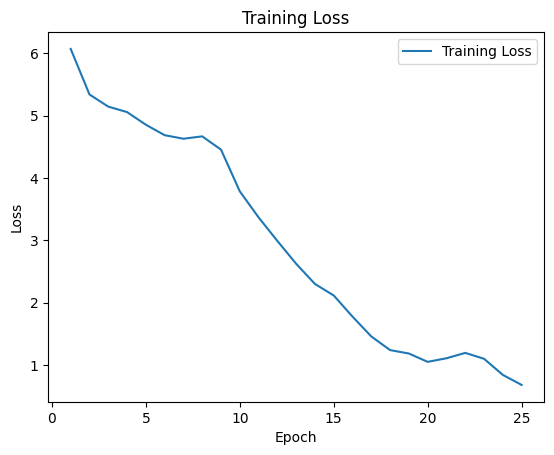

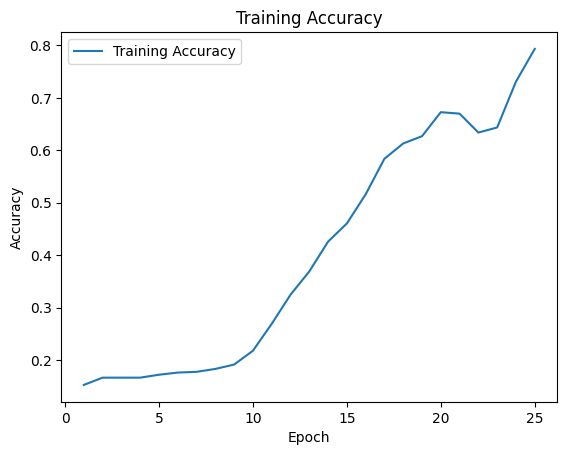

In [26]:
# Plotting the training loss
plt.plot(range(1, epochs+1), train_loss, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting the training accuracy
plt.plot(range(1, epochs+1), train_accuracy, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [27]:
test_generator = data_generator(test, mapping, features, tokenizer, max_length, vocab_size, batch_size)
test_steps = len(test) // batch_size

test_loss = model.evaluate(test_generator, steps=test_steps, verbose=1)
print("Test Loss:", test_loss)

7/7 [==============================] - 2s 14ms/step - loss: 12.5352 - accuracy: 0.1726
Test Loss: [12.535173416137695, 0.1726190447807312]


In [28]:
import json
tokenizer_json = tokenizer.to_json()

# Save the tokenizer to a file
with open('/content/drive/MyDrive/Project/Final_Dataset/notebooks/proposed model/nuswide/tokenizer_first.json', 'w', encoding='utf-8') as json_file:
    json_file.write(tokenizer_json)

In [29]:
import os
import os
import re
import pandas as pd
import pickle
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
import json
from tensorflow.keras.models import load_model as ld
from tkinter import filedialog
import json
import numpy as np
from tensorflow.keras.preprocessing.text import tokenizer_from_json
#from cap_gen import generate_caption



def idx_to_word(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None

# generate caption for an image
def predict_hashtag(model, image, tokenizer, max_length):
	# add start tag for generation process
	in_text = 'startseq'
	# iterate over the max length of sequence
	for i in range(max_length):
		# encode input sequence
		sequence = tokenizer.texts_to_sequences([in_text])[0]
		# pad the sequence
		sequence = pad_sequences([sequence], max_length)
		# predict next word
		yhat = model.predict([image, sequence], verbose=0)
		# get index with high probability
		yhat = np.argmax(yhat)
		# convert index to word
		word = idx_to_word(yhat, tokenizer)
		# stop if word not found
		if word is None:
			break
		# append word as input for generating next word
		in_text += " " + word
		# stop if we reach end tag
		if word == 'endseq':
			break

	return in_text



if __name__ == "__main__":
	image_model = InceptionV3(weights='imagenet')
	image_model = Model(inputs=image_model.input, outputs=image_model.layers[-2].output)

	with open('/content/drive/MyDrive/Project/Final_Dataset/notebooks/proposed model/nuswide/tokenizer_first.json', 'r', encoding='utf-8') as json_file:
		tokenizer_json = json_file.read()

	tokenizer = tokenizer_from_json(tokenizer_json)

	model = ld('/content/drive/MyDrive/Project/Final_Dataset/notebooks/proposed model/nuswide/model_amnn_solution_nuswide_first.h5')
	text_model = hub.load("https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/universal-sentence-encoder/versions/2")

	textt = input("Enter some text: ")
	text_feature = text_model([textt])[0].numpy()
	text_feature = np.expand_dims(text_feature, axis=0)

	img_path = '/content/car.jpg'
	image = load_img(img_path, target_size=(299, 299))
	image = img_to_array(image)
	image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
	image = preprocess_input(image)

	imfeature = image_model.predict(image, verbose=0)

	merged_feature = np.concatenate([imfeature, text_feature], axis=1)

	pr_h=predict_hashtag(model, merged_feature, tokenizer, 7)

	#print(pr_h)

	pr_h = pr_h.replace("startseq", "").replace("endseq", "")

	words = pr_h.split()

	# Add '#' to each word
	hashtags = ['#' + word.lower() for word in words]

	formatted_output = ' '.join(hashtags)

	print(formatted_output)
	formatted_output_without_hashtags = formatted_output.replace("#", "")
	#print(formatted_output_without_hashtags)
	# predicted_caption = generate_caption(formatted_output_without_hashtags)
	# print("Predicted Caption:", predicted_caption)

	# modified_text = predicted_caption.replace("eostok", "")

	# print(modified_text)






Enter some text: my favourite
#carstuff #carstuff #carspots #carslifestyle #carsonwentz


In [32]:
import os
import os
import re
import pandas as pd
import pickle
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
import json
from tensorflow.keras.models import load_model as ld
from tkinter import filedialog
import json
import numpy as np
from tensorflow.keras.preprocessing.text import tokenizer_from_json
#from cap_gen import generate_caption



def idx_to_word(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None

# generate caption for an image
def predict_hashtag(model, image, tokenizer, max_length):
	# add start tag for generation process
	in_text = 'startseq'
	# iterate over the max length of sequence
	for i in range(max_length):
		# encode input sequence
		sequence = tokenizer.texts_to_sequences([in_text])[0]
		# pad the sequence
		sequence = pad_sequences([sequence], max_length)
		# predict next word
		yhat = model.predict([image, sequence], verbose=0)
		# get index with high probability
		yhat = np.argmax(yhat)
		# convert index to word
		word = idx_to_word(yhat, tokenizer)
		# stop if word not found
		if word is None:
			break
		# append word as input for generating next word
		in_text += " " + word
		# stop if we reach end tag
		if word == 'endseq':
			break

	return in_text



if __name__ == "__main__":
	image_model = InceptionV3(weights='imagenet')
	image_model = Model(inputs=image_model.input, outputs=image_model.layers[-2].output)

	with open('/content/drive/MyDrive/Project/Final_Dataset/notebooks/proposed model/nuswide/tokenizer_first.json', 'r', encoding='utf-8') as json_file:
		tokenizer_json = json_file.read()

	tokenizer = tokenizer_from_json(tokenizer_json)

	model = ld('/content/drive/MyDrive/Project/Final_Dataset/notebooks/proposed model/nuswide/model_amnn_solution_nuswide_first.h5')
	text_model = hub.load("https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/universal-sentence-encoder/versions/2")

	textt = input("Enter some text: ")
	text_feature = text_model([textt])[0].numpy()
	text_feature = np.expand_dims(text_feature, axis=0)

	img_path = '/content/cat.jpg'
	image = load_img(img_path, target_size=(299, 299))
	image = img_to_array(image)
	image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
	image = preprocess_input(image)

	imfeature = image_model.predict(image, verbose=0)

	merged_feature = np.concatenate([imfeature, text_feature], axis=1)

	pr_h=predict_hashtag(model, merged_feature, tokenizer, 7)

	#print(pr_h)

	pr_h = pr_h.replace("startseq", "").replace("endseq", "")

	words = pr_h.split()

	# Add '#' to each word
	hashtags = ['#' + word.lower() for word in words]

	formatted_output = ' '.join(hashtags)

	print(formatted_output)
	formatted_output_without_hashtags = formatted_output.replace("#", "")
	#print(formatted_output_without_hashtags)
	# predicted_caption = generate_caption(formatted_output_without_hashtags)
	# print("Predicted Caption:", predicted_caption)

	# modified_text = predicted_caption.replace("eostok", "")

	# print(modified_text)






Enter some text: cutest pet ever
#catlifegoals #catlifestyle #catlifejourney #catlifeadventure #catlifewonderful


In [34]:
import os
import os
import re
import pandas as pd
import pickle
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
import json
from tensorflow.keras.models import load_model as ld
from tkinter import filedialog
import json
import numpy as np
from tensorflow.keras.preprocessing.text import tokenizer_from_json
#from cap_gen import generate_caption



def idx_to_word(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None

# generate caption for an image
def predict_hashtag(model, image, tokenizer, max_length):
	# add start tag for generation process
	in_text = 'startseq'
	# iterate over the max length of sequence
	for i in range(max_length):
		# encode input sequence
		sequence = tokenizer.texts_to_sequences([in_text])[0]
		# pad the sequence
		sequence = pad_sequences([sequence], max_length)
		# predict next word
		yhat = model.predict([image, sequence], verbose=0)
		# get index with high probability
		yhat = np.argmax(yhat)
		# convert index to word
		word = idx_to_word(yhat, tokenizer)
		# stop if word not found
		if word is None:
			break
		# append word as input for generating next word
		in_text += " " + word
		# stop if we reach end tag
		if word == 'endseq':
			break

	return in_text



if __name__ == "__main__":
	image_model = InceptionV3(weights='imagenet')
	image_model = Model(inputs=image_model.input, outputs=image_model.layers[-2].output)

	with open('/content/drive/MyDrive/Project/Final_Dataset/notebooks/proposed model/nuswide/tokenizer_first.json', 'r', encoding='utf-8') as json_file:
		tokenizer_json = json_file.read()

	tokenizer = tokenizer_from_json(tokenizer_json)

	model = ld('/content/drive/MyDrive/Project/Final_Dataset/notebooks/proposed model/nuswide/model_amnn_solution_nuswide_first.h5')
	text_model = hub.load("https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/universal-sentence-encoder/versions/2")

	textt = input("Enter some text: ")
	text_feature = text_model([textt])[0].numpy()
	text_feature = np.expand_dims(text_feature, axis=0)

	img_path = '/content/catbuilding.jpg'
	image = load_img(img_path, target_size=(299, 299))
	image = img_to_array(image)
	image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
	image = preprocess_input(image)

	imfeature = image_model.predict(image, verbose=0)

	merged_feature = np.concatenate([imfeature, text_feature], axis=1)

	pr_h=predict_hashtag(model, merged_feature, tokenizer, 7)

	#print(pr_h)

	pr_h = pr_h.replace("startseq", "").replace("endseq", "")

	words = pr_h.split()

	# Add '#' to each word
	hashtags = ['#' + word.lower() for word in words]

	formatted_output = ' '.join(hashtags)

	print(formatted_output)
	formatted_output_without_hashtags = formatted_output.replace("#", "")
	#print(formatted_output_without_hashtags)
	# predicted_caption = generate_caption(formatted_output_without_hashtags)
	# print("Predicted Caption:", predicted_caption)

	# modified_text = predicted_caption.replace("eostok", "")

	# print(modified_text)






Enter some text: city cuteness
#carsofinstagram #carsofinstagram #carswithoutlimits #carspotting #imaginationunleashed


In [ ]:
def precision_score(test_y, pred_y, k=1):
    p_score = []

    for i in range(len(test_y)):
        # print(pred_y[i][-k:])
        # print(pred_y[i][-k])
        # result_at_topk = pred_y[i][-k:]
        count = 0
        for j in range(0,k):
            if(pred_y[i][j] in test_y[i]):
                count+=1
        p_score.append(float(count) / float(k))
            # if j in test_y[i]:
                # count += 1
        # p_score.append(float(count) / float(k))

    return np.mean(p_score)

def recall_score(test_y, pred_y, k=1):
    r_score = []
    for i in range(len(test_y)):
        count = 0
        end=min(k,len(pred_y[i]))
        for j in range(0,end):
            if(pred_y[i][j] in test_y[i]):
                count+=1
        r_score.append(float(count) / float(len(test_y[i])))

    return np.mean(r_score)


precision = precision_score(test_y, pred_y, k=1)
recall = recall_score(test_y, pred_y, k=1)

# Print precision and recall values
print("Precision @ 1:", precision)
print("Recall @ 1:", recall)

NameError: name 'test_y' is not defined

In [ ]:
y_true = []

#print("Hashtags for image ID", image_id, ":", hashtags)
for image_id in test:
  print(image_id)
  row = df[df['File Name'] == image_id+'.jpg']
  hashtags = row['Pre_hashtag'].values[0]
  print(hashtags)
  y_true.append(hashtags)


0098_2192794779


IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

print("Precision:", precision)
print("Recall:", recall)

NameError: name 'y_pred' is not defined

In [ ]:
row = df[df['File Name'] == '1.jpg']
print(row['Pre_Hashtags'].values[0])

KeyError: 'Pre_Hashtags'